From $z$-domain, use SoftClip first and then Exp bijectors. May be a bit counterintuitive, the other way around causes numerical instability (divergence of log likelihood) around $b$, the upper boundary, because Exp will make outliers in the $z$-domain even more outliers close to $b$.

The default "temperatures" (scales) for SoftClip are so good (we set them to $\hat\sigma_i$ for dimension $i$) that we only optimize rescaling factors for $\hat\Sigma$. That is, optimize $$\Sigma = diag(s_1 \sigma_1, s_2 \sigma_2, \ldots) \hat{C} diag(s_1 \sigma_1, s_2 \sigma_2, \ldots)$$ for $s_i \sim Exp(1)$ and where $\hat{C}$ is the estimated correlation matrix, i.e. $$\hat{\Sigma} = diag(\sigma_1, \sigma_2, \ldots) \hat{C} diag(\sigma_1, \sigma_2, \ldots)$$. This results in vanishing log likelihoods near the boundaries $(a, b)$, which, if slightly unrealistic, brings so many numerical advantages (for example in ADVI) that we are happy with this behavior.

We use dynesty as our global likelihood maximizer (10 min), but it also works with jaxns on CPU (13 min) and on GPU (3 min) on Google Colab.

Note: results for jaxns on Google Colab: CPU: 10 min, **GPU: 3 min!**, TPU: 15 min.

In [1]:
%run init.ipy
from dgf import core
from dgf import isokernels
from dgf import constants
from dgf import bijectors
from dgf.prior import lf
from dgf.prior import source

import corner

import dynesty
import scipy.stats

In [2]:
p = lf.sample_lf_params()

[Memory]3.4s, 0.1min    : Loading sample_lf_params...


In [3]:
samples = np.vstack([p[v] for v in constants.LF_GENERIC_PARAMS]).T
samples.shape

(65913, 4)

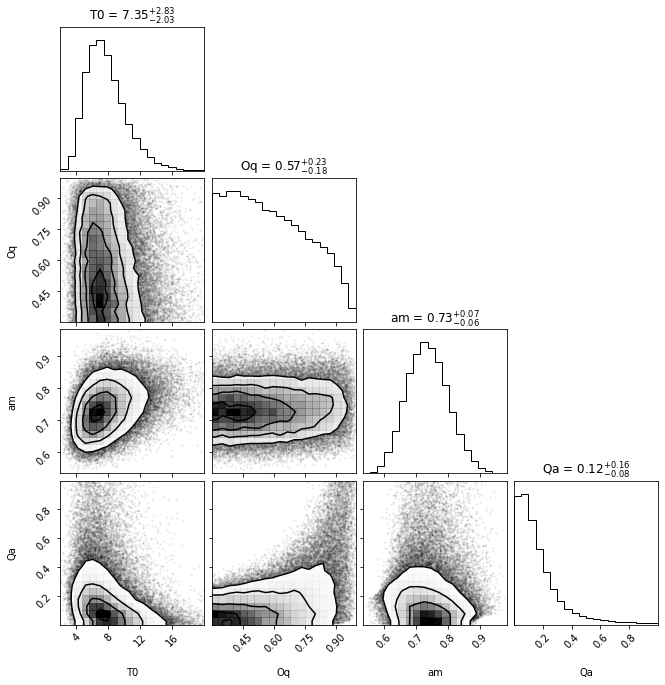

In [4]:
# Cornerplot of regressed (simulated) samples
fig = corner.corner(
    samples,
    labels=constants.LF_GENERIC_PARAMS,
    show_titles=True,
    smooth=.2
)

In [5]:
z = np.log(samples)
z_mean = np.mean(z, axis=0)
z_cov = np.cov(z.T)
z_sigma = np.sqrt(np.diag(z_cov))
z_corr = np.diag(1/z_sigma) @ z_cov @ np.diag(1/z_sigma)
L_z_corr = np.linalg.cholesky(z_corr)

z_bounds = np.log(np.array([
    constants.LF_GENERIC_BOUNDS[k] for k in constants.LF_GENERIC_PARAMS
]))

In [6]:
# Note: **not using JAX**
import tensorflow_probability.python.distributions as tfd
import tensorflow_probability.python.bijectors as tfb

static_bijector = tfb.Chain([
    tfb.Exp(), tfb.SoftClip(
        z_bounds[:,0], z_bounds[:,1], z_sigma
    )
])

def getprior(rescale):
    L = np.diag(rescale*z_sigma) @ L_z_corr
    prior = tfd.TransformedDistribution(
        distribution=tfd.MultivariateNormalTriL(
            loc=z_mean,
            scale_tril=L
        ),
        bijector=static_bijector
    )
    return prior

def loglike(rescale, data=samples):
    prior = getprior(rescale)
    lp = np.sum(prior.log_prob(data))
    return -np.inf if np.isnan(lp) else float(lp)

def ptform(
    u,
    rescale_prior=scipy.stats.expon(scale=1.)
):
    return rescale_prior.ppf(u)

ndim = len(constants.LF_GENERIC_PARAMS)
sampler = dynesty.NestedSampler(loglike, ptform, ndim, nlive=ndim*5)
sampler.run_nested()
results = sampler.results

587it [09:04,  1.08it/s, +20 | bound: 165 | nc: 1 | ncall: 6710 | eff(%):  9.073 | loglstar:   -inf < 26352.383 <    inf | logz: 26327.299 +/-  1.065 | dlogz:  0.001 >  0.029]


In [7]:
# Rescale (stretch) factors
results.samples[-1,:]

array([1.13937055, 1.79653223, 1.07012635, 1.30428451])

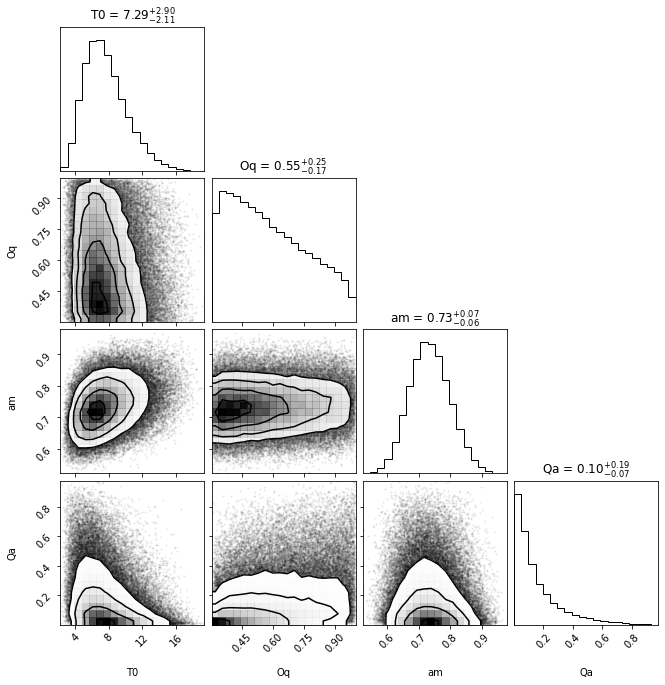

In [8]:
priorml = getprior(results.samples[-1,:])

fig = corner.corner(
    np.array(priorml.sample(100000)),
    labels=constants.LF_GENERIC_PARAMS,
    show_titles=True,
    smooth=.2
)

In [26]:
# Note: **using JAX**
from jaxns import GlobalOptimiser, PriorChain
from jaxns.prior_transforms import GammaPrior

import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

static_bijector = tfb.Chain([
    tfb.Exp(), tfb.SoftClip(
        z_bounds[:,0], z_bounds[:,1], z_sigma
    )
])

def getprior(rescale):
    L = jnp.diag(rescale*z_sigma) @ L_z_corr
    prior = tfd.TransformedDistribution(
        distribution=tfd.MultivariateNormalTriL(
            loc=z_mean,
            scale_tril=L
        ),
        bijector=static_bijector
    )
    return prior

def loglike(rescale, data=samples):
    prior = getprior(rescale)
    lp = jnp.sum(prior.log_prob(data))
    return lp
    #return -jnp.inf if jnp.isnan(lp) else lp

ExponentialPrior = lambda s, ndim: GammaPrior(s, jnp.ones(ndim), jnp.ones(ndim))

with PriorChain() as prior_chain:
    ExponentialPrior("rescale", ndim)

go = GlobalOptimiser(
    loglikelihood=loglike, prior_chain=prior_chain,
    num_parallel_samplers=1
)

In [27]:
%%time
# 13 min walltime on CPU, 3 mins on Google Colab with GPU
goresults = jax.jit(go)(jax.random.PRNGKey(32564), termination_patience=2)

CPU times: user 23min 35s, sys: 26.5 s, total: 24min 1s
Wall time: 14min 11s


In [28]:
go.summary(goresults) # Same results

--------
Termination Conditions:
Small enough likelihood change with patience
--------
# likelihood evals: 164548
# samples: 3680
# likelihood evals / sample: 44.7
--------
Maximum logL=26000.0
--------
rescale[#]: max(L) est.
rescale[0]: 1.139715
rescale[1]: 1.796602
rescale[2]: 1.070661
rescale[3]: 1.303635
--------


'--------\nTermination Conditions:\nSmall enough likelihood change with patience\n--------\n# likelihood evals: 164548\n# samples: 3680\n# likelihood evals / sample: 44.7\n--------\nMaximum logL=26000.0\n--------\nrescale[#]: max(L) est.\nrescale[0]: 1.139715\nrescale[1]: 1.796602\nrescale[2]: 1.070661\nrescale[3]: 1.303635\n--------'